In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import os
import argparse
from functools import partial



In [ ]:
class BinScale(object):
    def __init__(self, num_bits=8):
        self.num_bits = num_bits
        self.num_bins = int(2 ** num_bits)
    
    def __call__(self, x): # [0, 1] -> # [0, (2 **num_bits - 1)]
        return x * (self.num_bins - 1)


def update_ema(ema_model, model, ema_rate):
    for tar, src in zip(ema_model.parameters(), model.parameters()):
        if tar.data.dtype == torch.bool:
            tar.data = src.data
        else:
            tar.data.mul_(ema_rate).add_(src.data * (1 - ema_rate))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


In [ ]:
# class Inv1x1(nn.Module):
#     def __init__(self, chs):
#         super().__init__()

#         def get_inv1x1_components(chs):
#             w = torch.empty(chs, chs)
#             nn.init.orthogonal_(w)
#             pmat, lmat, umat = torch.lu_unpack(*torch.lu(w))
#             diag = torch.diag(umat)
#             l_mask = torch.tril(torch.ones(chs, chs), diagonal=1)
#             u_mask = torch.tril(torch.ones(chs, chs), diagonal=-1).transpose(0, 1)
#             sign = torch.sign(diag)
#             logs = torch.log(abs(diag))
#             eye = torch.eye(chs)
#             return pmat, lmat, umat, logs, sign, u_mask, l_mask, eye

#         pmat, lmat, umat, logs, sign, u_mask, l_mask, eye = get_inv1x1_components(chs)
#         self.pmat = nn.Parameter(pmat, requires_grad=False)
#         self.u_mask = nn.Parameter(u_mask, requires_grad=False)
#         self.l_mask = nn.Parameter(l_mask, requires_grad=False)
#         self.eye = nn.Parameter(eye, requires_grad=False)
        
#         # self.sign = nn.Parameter(sign, requires_grad=True)
#         self.sign = nn.Parameter(sign, requires_grad=False)

#         self.lmat = nn.Parameter(lmat, requires_grad=True)
#         self.umat = nn.Parameter(umat, requires_grad=True)
#         self.logs = nn.Parameter(logs, requires_grad=True)


#     def get_w(self):
#         p = self.pmat
#         l = (self.lmat * self.l_mask)
#         u = (self.umat * self.u_mask) + (self.logs.exp() * self.sign) * self.eye
#         return p @ l @ u

#     def forward(self, x, sldj, reverse=False):
#         if not reverse:
#             w = self.get_w()
#             logdet = x.size()[2] * x.size()[3] * torch.sum(self.logs)
#             sldj = sldj + logdet
#             return F.conv2d(x, w.unflatten(-1, (-1, 1, 1))), sldj

#         else:
#             w_inv = self.get_w().double().inverse().float()
#             logdet = - x.size()[2] * x.size()[3] * torch.sum(self.logs)
#             sldj = sldj + logdet
#             return F.conv2d(x, w_inv.unflatten(-1, (-1, 1, 1))), sldj


class Inv1x1(nn.Module):
    def __init__(self, chs):
        super().__init__()
        w = torch.empty(chs, chs)
        nn.init.orthogonal_(w)
        self.w = nn.Parameter(w)

    def forward(self, x, sldj, reverse=False):
        if not reverse:
            ldj = torch.slogdet(self.w)[1] * x.size(2) * x.size(3)            
            sldj = sldj + ldj
            x = F.conv2d(x, self.w.unflatten(-1, (-1, 1, 1)))
            return x, sldj

        else:
            ldj = - torch.slogdet(self.w)[1] * x.size(2) * x.size(3)            
            sldj = sldj + ldj
            w_inv = torch.inverse(self.w.double()).float()
            x = F.conv2d(x, w_inv.unflatten(-1, (-1, 1, 1)))
            return x, sldj


class ActNorm(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.logs = nn.Parameter(torch.zeros(1, chs, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, chs, 1, 1))
        self.init_done = nn.Parameter(torch.BoolTensor([False]), requires_grad=False)

    def data_dependent_init(self, x):
        if not self.init_done:
            with torch.no_grad():
                std, mean = torch.std_mean(x, dim=[0, 2, 3], unbiased=False, keepdim=True)
                self.bias.data.copy_(-mean.data)
                self.logs.data.copy_(std.add(1e-8).log().neg().data)

            self.init_done.fill_(True)

    def forward(self, x, sldj, reverse=False):
        if not reverse:
            if not self.init_done:
                self.data_dependent_init(x)
            
            ldj = self.logs.sum(dim=[1, 2, 3]) * x.size()[2] * x.size()[3]
            x = self.logs.exp() * (x + self.bias)
        
        else:
            x = x * self.logs.neg().exp() - self.bias
            ldj = - self.logs.sum(dim=[1, 2, 3]) * x.size()[2] * x.size()[3]

        sldj = sldj + ldj
        return x, sldj


class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same", dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        if self.bias is not None:
            self.bias.data *= 0.


class WnConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same", dilation=1, groups=1, bias=True, init_scale=1., data_init=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        wn = self.weight.square().sum(dim=[1, 2, 3], keepdim=True).sqrt().add(1e-8).log()

        self.init_scale = init_scale
        self.logs = nn.Parameter(wn + np.log(self.init_scale), requires_grad=True)

        if self.bias is not None:
            self.bias.data *= 0.

        self.init_done = nn.Parameter(torch.BoolTensor([False if data_init else True]), requires_grad=False)

    def forward(self, x):
        if not self.init_done:
            self.data_dependent_init(x)
            
        return F.conv2d(x, self.weight_normalized(), self.bias, self.stride, self.padding, self.dilation, self.groups)

    def weight_normalized(self):
        rwn = self.weight.square().sum(dim=[1, 2, 3], keepdim=True).add(1e-8).rsqrt()
        g = self.logs.exp() * rwn
        return g * self.weight

    def data_dependent_init(self, x):
        if not self.init_done:
            with torch.no_grad():
                rwn = self.weight.square().sum(dim=[1, 2, 3], keepdim=True).add(1e-8).rsqrt()

                weight = self.weight * rwn
                out = F.conv2d(x, weight, None, self.stride, self.padding, self.dilation, self.groups)

                out_var, out_mean = torch.var_mean(out, dim=[0, 2, 3], unbiased=False, keepdim=False)
                out_std = out_var.add(1e-8).sqrt()

                if self.bias is not None:
                    self.bias.data = - out_mean / out_std

                self.logs.data = - torch.log(out_std).unflatten(0, (-1, 1, 1, 1)) + np.log(self.init_scale)
                
            self.init_done.fill_(True)



In [ ]:
class NN(nn.Module):
    def __init__(self, in_chs, hid_chs):
        super().__init__()
        self.conv = [WnConv2d(in_chs, hid_chs, 3, bias=False, data_init=False),
                     nn.ELU(),
                     WnConv2d(hid_chs, hid_chs, 1, bias=False, data_init=False),
                     nn.ELU(),
                     WnConv2d(hid_chs, 2 * in_chs, 3, bias=True, init_scale=0.01, data_init=False)] # small init_scale of output conv is important

        self.conv = nn.Sequential(*self.conv)
                     
    def forward(self, x):
        return self.conv(x)



In [ ]:
class Coupling(nn.Module):
    def __init__(self, in_chs_half, hid_chs):
        super().__init__()
        self.nn = NN(in_chs_half, hid_chs)
        self.scale = nn.Parameter(torch.zeros(in_chs_half, 1, 1))

    def forward(self, x, sldj, reverse=False):

        x_trans, x_pivot = x.chunk(2, dim=1)
        stdv, bias = self.nn(x_pivot).chunk(2, dim=1)
        logs = (F.softplus(self.scale, np.log(2.)) * F.softplus(stdv, np.log(2.))).log()

        if not reverse:
            x_trans = (x_trans + bias) * logs.exp()
            ldj = logs.sum(dim=[1, 2, 3])

        else:
            x_trans = x_trans * logs.neg().exp() - bias
            ldj = - logs.sum(dim=[1, 2, 3])

        x = torch.cat([x_trans, x_pivot], dim=1)
        sldj = sldj + ldj
        return x, sldj



In [ ]:
# https://github.com/chrischute/glow

class PixelSqueeze(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sldj=None, reverse=False):
        b, c, h, w = x.size()

        if reverse:
            x = x.view(b, c // 4, 2, 2, h, w)
            x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
            x = x.view(b, c // 4, h * 2, w * 2)
        else:
            x = x.view(b, c, h // 2, 2, w // 2, 2)
            x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
            x = x.view(b, c * 2 * 2, h // 2, w // 2)

        return x, sldj

In [ ]:
class Flip(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sldj=None, reverse=False):
        x_a, x_b = x.chunk(2, 1)
        x = torch.cat([x_b, x_a], 1)
        return x, sldj

In [ ]:
class FlowStep(nn.Module):
    def __init__(self, in_chs, hid_chs, use_inv1x1=True):
        super().__init__()
        self.norm = ActNorm(in_chs)
        self.invertible = Inv1x1(in_chs) if use_inv1x1 else Flip()
        self.coup = Coupling(in_chs // 2, hid_chs)

    def forward(self, x, sldj=None, reverse=False):
        if not reverse:
            x, sldj = self.norm(x, sldj, reverse)
            x, sldj = self.invertible(x, sldj, reverse)
            x, sldj = self.coup(x, sldj, reverse)           
        
        else:
            x, sldj = self.coup(x, sldj, reverse)
            x, sldj = self.invertible(x, sldj, reverse)
            x, sldj = self.norm(x, sldj, reverse)

        return x, sldj

In [ ]:
# uniform dequantization: https://arxiv.org/abs/1902.00275

class UniformDequantizer(nn.Module):
    def __init__(self, num_bits=8):
        super().__init__()
        self.num_bits = num_bits
        self.num_bins = int(2 ** num_bits)

    def sample(self, x): # x in {0, ..., 255}
        u = torch.rand_like(x)
        log_qu = (torch.ones_like(u)).log().sum(dim=[1, 2, 3])
        x = x + u # {0, ... 256}
        return x, log_qu

In [ ]:
class BinNormalizer(nn.Module):
    def __init__(self, num_bits=8):
        super().__init__()
        self.num_bits = num_bits
        self.num_bins = int(2 ** num_bits)

    def forward(self, x, sldj=None, reverse=False):
        if sldj is None:
            sldj = 0.

        if not reverse:            

            x = x / self.num_bins   # {0,  1}
            ldj = ((1 / self.num_bins) * torch.ones_like(x)).log().sum(dim=[1, 2, 3])
            sldj = sldj + ldj
            return x, sldj

        else:
            x = x * self.num_bins
            ldj = - ((1 / self.num_bins) * torch.ones_like(x)).log().sum(dim=[1, 2, 3])
            sldj = sldj + ldj


            return x, sldj


class Normalizer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sldj=None, reverse=False):
        if not reverse:            
            x = 2 * x - 1
            ldj = (2 * torch.ones_like(x)).log().sum(dim=[1, 2, 3])
            sldj = sldj + ldj
            return x, sldj

        else:
            x = 0.5 * (x + 1)
            ldj = - (2 * torch.ones_like(x)).log().sum(dim=[1, 2, 3])
            sldj = sldj + ldj
            return x, sldj


In [ ]:

class GlowBlock(nn.Module):
    def __init__(self, in_chs, hid_chs, num_steps, split=True):
        super().__init__()
        self.squeeze = PixelSqueeze()
        self.steps = nn.ModuleList([FlowStep(in_chs, hid_chs) for _ in range(num_steps)])

        self.split = split

    def forward(self, x, sldj):
        x, sldj = self.squeeze(x, sldj, reverse=False)
        for step in self.steps:
            x, sldj = step(x, sldj, reverse=False)
        
        if self.split:
            x, x_split = x.chunk(2, 1)
        else:
            x_split = None

        return x, sldj, x_split



    def reverse(self, x, sldj, x_split=None):
        if self.split:
            x = torch.cat([x, x_split], 1)
        
        for step in reversed(self.steps):
            x, sldj = step(x, sldj, reverse=True)
        x, sldj = self.squeeze(x, sldj, reverse=True)
        return x, sldj



In [ ]:
class Prior(nn.Module):
    def __init__(self, chs, rsl, learnable=True):
        super().__init__()
        self.loc = nn.Parameter(torch.zeros(chs, rsl, rsl), requires_grad=learnable)
        self.std = nn.Parameter(torch.zeros(chs, rsl, rsl), requires_grad=learnable)

    def log_prob(self, z):
        loc = self.loc
        std = F.softplus(self.std, np.log(2))
        return D.Normal(loc, std).log_prob(z)

    def sample(self, batch_size):
        loc = self.loc
        std = F.softplus(self.std, np.log(2))
        return D.Normal(loc, std).rsample([batch_size])   


In [ ]:
def get_shapes(img_chs, img_rsl, splits):
    num_levels = len(splits)

    ch, rsl = img_chs * 4, img_rsl // 2
    level_shapes = []
    for lv, lv_split in enumerate(splits):       
        level_shapes.append((ch, rsl, rsl))
        ch = ch * 2 if lv_split else ch * 4
        rsl = rsl // 2
        
    return level_shapes


class Glow(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.shapes = get_shapes(args.img_chs, args.img_rsl, args.splits)
        self.flows = []
        self.priors = []
        self.num_levels = len(args.chs)

        for lv, lv_split in enumerate(args.splits):
            flow = GlowBlock(in_chs=self.shapes[lv][0], hid_chs=args.chs[lv], num_steps=args.num_steps[lv], split=lv_split)

            if lv_split:
                prior = Prior(self.shapes[lv][0] // 2, self.shapes[lv][1], learnable=args.learnable_prior)

            elif lv == self.num_levels - 1:
                prior = Prior(self.shapes[lv][0], self.shapes[lv][1], learnable=args.learnable_prior)
            
            else:
                prior = None
        
            self.flows.append(flow)
            self.priors.append(prior)

        self.flows = nn.ModuleList(self.flows)
        self.priors = nn.ModuleList(self.priors)

        self.dequantizer = UniformDequantizer()
        self.bin_norm = BinNormalizer()
        self.img_norm = Normalizer()


    def forward(self, x):
        sldj = torch.zeros(x.size(0), device=x.device)
        log_pz = torch.zeros_like(sldj)
        outs = []

        x, sldj = self.bin_norm(x, sldj, reverse=False)
        x, sldj = self.img_norm(x, sldj, reverse=False)
        for lv, flow in enumerate(self.flows):
            
            last = True if lv == self.num_levels - 1 else False
            if not last:
                x, sldj, out = flow(x, sldj)
        
            else:
                out, sldj, _ = flow(x, sldj)

            if self.priors[lv] is not None:
                log_pz = log_pz + self.priors[lv].log_prob(out).sum(dim=[1, 2, 3])

            outs.append(out)
 
        return outs, log_pz, sldj


    def reverse(self, x_splits):
        sldj = torch.zeros(x_splits[-1].size(0), device=x_splits[-1].device)
        log_pz = torch.zeros_like(sldj)

        for lv, flow in list(enumerate(self.flows))[::-1]:
            last = True if lv == self.num_levels - 1 else False

            z = x_splits.pop()
            if self.priors[lv] is not None:
                log_pz = log_pz + self.priors[lv].log_prob(z).sum(dim=[1, 2, 3])

            if last:
                x, sldj = flow.reverse(z, sldj, None)
                
            else:
                x, sldj = flow.reverse(x, sldj, z)

        x, sldj = self.img_norm(x, sldj, reverse=True)
        _, sldj = self.bin_norm(x, sldj, reverse=True)
        return x, log_pz, sldj

    def dequantize(self, x):
        x, log_qu = self.dequantizer.sample(x)
        return x, log_qu

    def sample_z(self, batch_size):
        zs = []
        for lv, prior in enumerate(self.priors):
            if prior is None:
                zs.append(None)
            else:
                zs.append(prior.sample(batch_size))
        return zs

In [ ]:
args = argparse.Namespace()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.chs        = [  512,   512,   512]
args.num_steps  = [   32,    32,    32]
args.splits     = [ True,  True, False]

args.learnable_prior = True
assert args.splits[-1] == False



args.num_epochs = 80
args.batch_size = 64
args.learning_rate = 1e-3
args.ema_rate = 0.999

args.img_rsl   = 32
args.img_chs   = 3
args.num_bits  = 8



model = Glow(args).to(args.device)

ema_model = copy.deepcopy(model)
ema_model.requires_grad_(False)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), BinScale(args.num_bits)])
test_transform = transforms.Compose([transforms.ToTensor(), BinScale(args.num_bits)])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
test_dataset  = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
loss_meter = AverageMeter()

for epoch in range(args.num_epochs):
    loss_meter.reset()
    for x, y in loader:       
        x = x.to(args.device)
        optimizer.zero_grad()
        x, log_qu = model.dequantize(x)
        outs, log_pz, sldj = model(x)
        loss = (- log_pz - sldj + log_qu).mean()
        loss.backward()
        optimizer.step()
        update_ema(ema_model, model, args.ema_rate)
        loss_meter.update(loss.item(), x.size()[0])

    print('[epoch %3d] | %s: %7.5f |' % (epoch, 'bpd', loss_meter.avg / (3 * 32 * 32 * np.log(2))))

[epoch   0] | bpd: 4.19873 |
[epoch   1] | bpd: 3.89416 |
[epoch   2] | bpd: 3.79951 |
[epoch   3] | bpd: 3.74140 |
[epoch   4] | bpd: 3.70021 |
[epoch   5] | bpd: 3.66875 |
[epoch   6] | bpd: 3.63867 |
[epoch   7] | bpd: 3.61834 |
[epoch   8] | bpd: 3.60284 |
[epoch   9] | bpd: 3.58336 |
[epoch  10] | bpd: 3.57410 |
[epoch  11] | bpd: 3.55841 |
[epoch  12] | bpd: 3.54995 |
[epoch  13] | bpd: 3.54060 |
[epoch  14] | bpd: 3.53143 |
[epoch  15] | bpd: 3.52586 |
[epoch  16] | bpd: 3.51866 |
[epoch  17] | bpd: 3.51133 |
[epoch  18] | bpd: 3.50465 |
[epoch  19] | bpd: 3.50134 |
[epoch  20] | bpd: 3.49376 |
[epoch  21] | bpd: 3.49058 |
[epoch  22] | bpd: 3.48381 |
[epoch  23] | bpd: 3.47952 |
[epoch  24] | bpd: 3.47613 |
[epoch  25] | bpd: 3.47087 |
[epoch  26] | bpd: 3.46896 |
[epoch  27] | bpd: 3.46465 |
[epoch  28] | bpd: 3.45994 |
[epoch  29] | bpd: 3.45723 |
[epoch  30] | bpd: 3.45318 |
[epoch  31] | bpd: 3.44959 |
[epoch  32] | bpd: 3.44648 |
[epoch  33] | bpd: 3.44317 |
[epoch  34] | 

KeyboardInterrupt: ignored

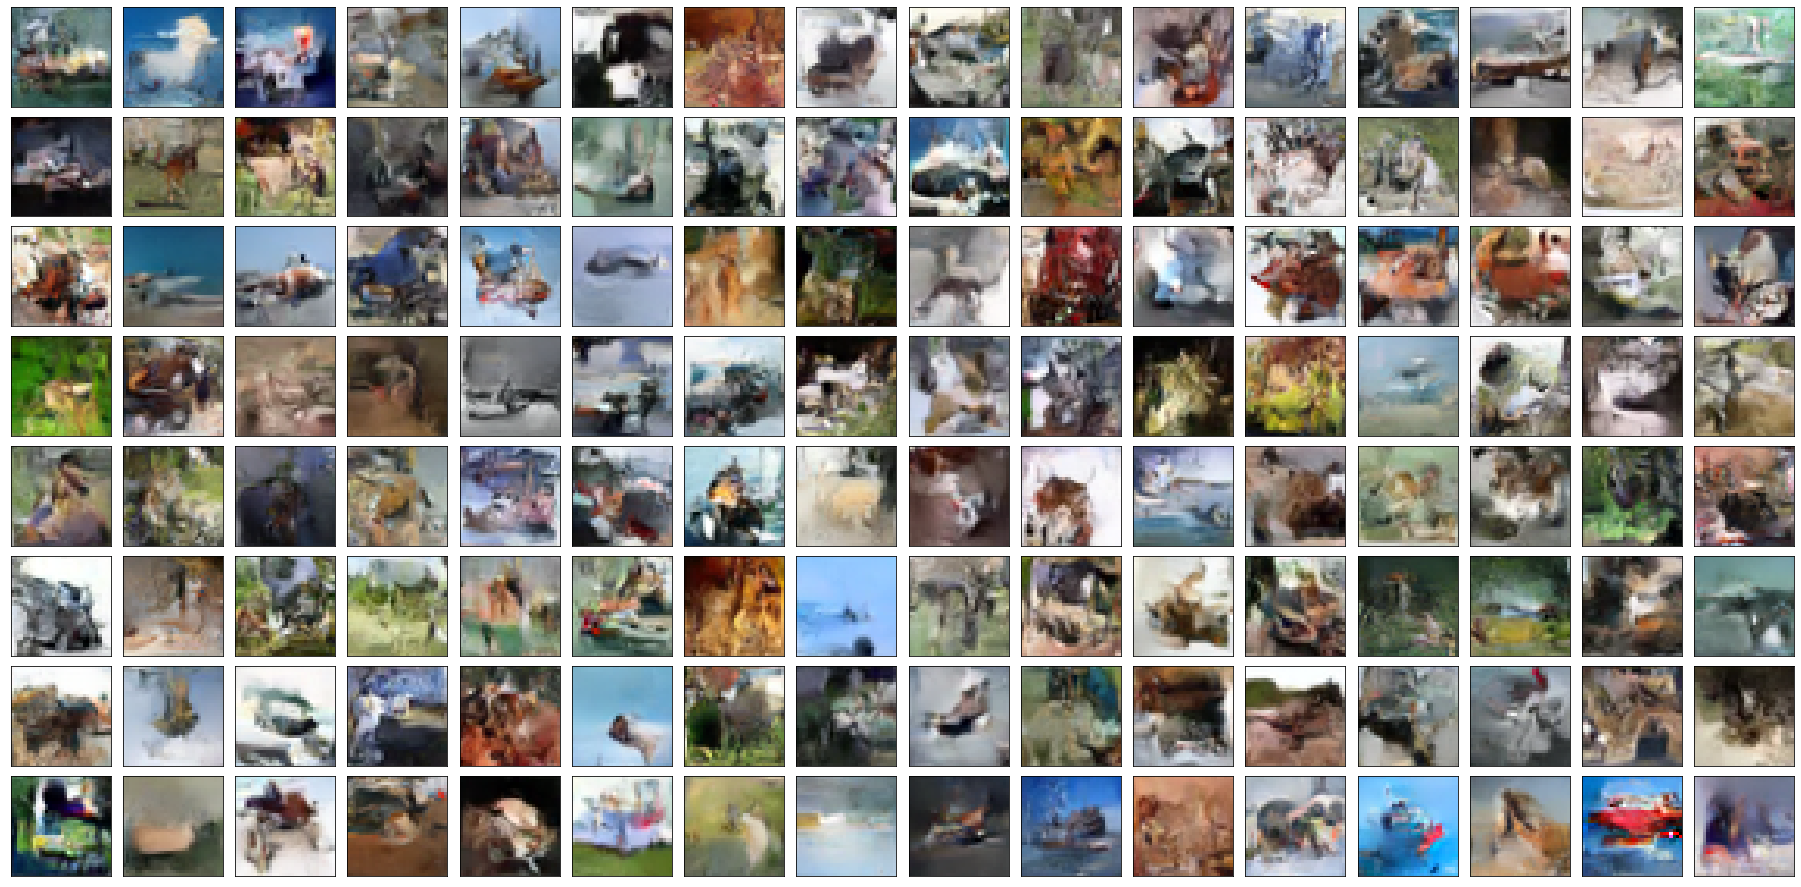

In [ ]:
@torch.no_grad()
def generate(model, batch_size, temperature=1.):
    outs = model.sample_z(batch_size)
    for i in range(len(outs)):
        if outs[i] is not None:
            outs[i] = outs[i] * temperature

    gen, log_pz, sldj = model.reverse(outs)
    gen = torch.clamp(gen, 0., 1.).permute(0, 2, 3, 1).detach().cpu().numpy()
    return gen

gen = generate(ema_model, batch_size=128, temperature=1.)
fig = plt.figure(figsize=(32, 16))
for i in range(8 * 16):
    sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
    sub_fig.imshow(gen[i])

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

In [ ]:
# reconstruction evaluation

@torch.no_grad()
def test(model, batch_size=64):
    loader = DataLoader(test_dataset, batch_size, shuffle=False, drop_last=False)
    loss_meter = AverageMeter()
    for x, y in loader:        
        x = x.to(args.device)
        x, log_qu = model.dequantize(x)
        outs, log_pz, sldj = model(x)
        loss = (- log_pz - sldj + log_qu).mean()
        loss_meter.update(loss.item(), x.size()[0])

    print(f"bpd: {loss_meter.avg / (3 * 32 * 32 * np.log(2))}")

test(ema_model)

bpd: 3.4459707840673524


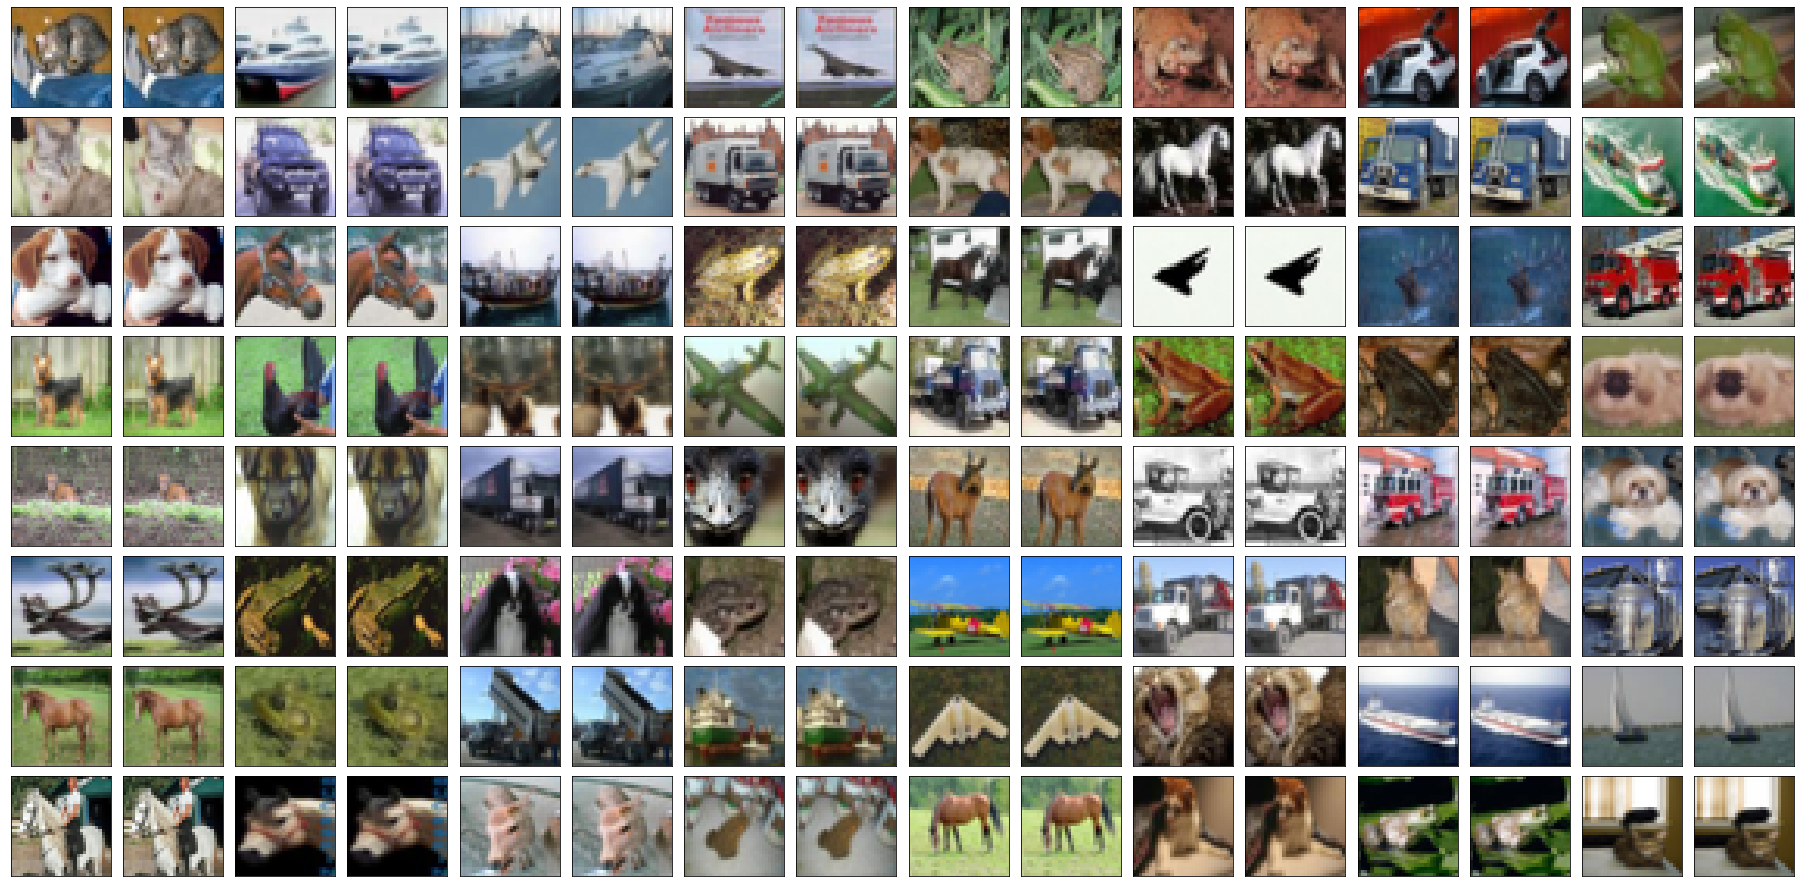

In [ ]:
# reconstruction evaluation

@torch.no_grad()
def reconstruct(model, x):
    x = x.to(args.device)
    x, log_qu = model.dequantize(x)

    outs, log_pz, sldj = model(x)
    bpd = (- log_pz - sldj + log_qu) / (3 * 32 * 32 * np.log(2))
    x, log_pz, sldj = model.reverse(outs)

    recon = torch.clamp(x, 0., 1.).permute(0, 2, 3, 1).detach().cpu().numpy()
    return recon, bpd

x, _ = next(iter(DataLoader(test_dataset, 64, shuffle=False, drop_last=False)))
x_org = x.permute(0, 2, 3, 1) / (2 ** args.num_bits - 1)
gen, bpd = reconstruct(model, x)

fig = plt.figure(figsize=(32, 16))
n = 0
for i in range(8 * 8):
    _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_org[i])
    n += 1

    _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
    _fig.imshow(gen[i])
    n += 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()


# left: original
# right: reconstructed